In [15]:
# copy dataset from repo + cleanup
import shutil

!git clone https://github.com/lemonpudding-datasets/cifar10.git

shutil.move("cifar10/Data", "Data/cifar3")
shutil.rmtree('cifar10')

Cloning into 'cifar10'...
remote: Enumerating objects: 18014, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 18014 (delta 0), reused 2 (delta 0), pack-reused 18012
Receiving objects: 100% (18014/18014), 6.08 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (17992/17992), done.


## Imports

In [16]:
# ONLY USE THESE IMPORTS.
# PLEASE DON'T EDIT THIS CELL.
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
confusion_matrices_nb = []
confusion_matrices_gm = []

## Read Data

In [17]:
# cannot import OS :(, i have to hardcode folder names.
def load_raw_set(train_test):
  path = 'Data/cifar3/' + train_test
  classes = ['airplane', 'automobile', 'frog']
  imgs_per_class = 5000 if train_test == 'train' else 1000

  # data shape
  n = imgs_per_class * len(classes)
  m = 32
  p = 32
  l = 3

  # allocate memory in advance (faster)
  X = np.zeros(shape=(n,m, p, l))
  y = np.zeros(shape=(n,), dtype=object)

  # load all images 
  for class_indx, class_name in enumerate(classes):
    for img_indx in range(imgs_per_class):
      img_path = path + '/' + class_name + '/' + str(img_indx) + '.jpg'
      
      # each RGB image is loaded then added to the dataset
      set_indx = imgs_per_class * class_indx + img_indx - 1
      X[set_indx] = plt.imread(img_path)
      y[set_indx] = class_indx
  return X, y

## Image Resizing & Flattening

In [18]:
def resize_flatten(dataset, new_size=32):

  # new dimesions after flattening 
  n = dataset.shape[0]
  m = new_size * new_size * dataset.shape[3]

  # allocate memory in advance (faster)
  X = np.zeros(shape=(n,m))

  for indx, img in enumerate(dataset):

    # resize image if the new size is different from the old
    if(new_size != dataset.shape[1]):
      img = cv2.resize(img, (new_size,new_size), interpolation=cv2.INTER_AREA)
    
    # flatten image and save it (n, new_size * new size * 3)
    X[indx] = img.reshape(1, -1)
  return X


## Scale Training Set

In [19]:
# load train and test sets, then scale them
X_train_raw, y_train = load_raw_set('train')
X_train_raw /= 255

X_test_raw, y_test = load_raw_set('test')
X_test_raw /= 255

## Gaussian Generative Model Classifier

### Helper Functions

#### I. Group Dataset by Class

In [21]:
# useful for future calculations
def split_classes(samples, labels):
  # a dictionary having labels as keys, and a list of samples as values for each label
  label_dict = {0: [], 1: [], 2: []}

  # assign samples to their buckets
  for indx, sample in enumerate(samples):
    label = labels[indx]
    label_dict[label].append(sample)

  # convert lists into numpy arrays
  label_dict[0] = np.array(label_dict[0])
  label_dict[1] = np.array(label_dict[1])
  label_dict[2] = np.array(label_dict[2])

  return label_dict

#### II. Gaussian Parameters For a Given Set

In [22]:
# features (pixels) are normally distributed
# we need a way to calculate feature parameters (mean, std)
def get_params(samples, get_std):
  params = {"mean": []}

  if(get_std):
    params["std"] = []

  for feature in samples.T:
    params["mean"].append(feature.mean()) # add feature mean to means

    if(get_std):
      params["std"].append(feature.std()) # add feature std to stds

  # convert lists into numpy arrays
  params["mean"] = np.array(params["mean"])

  if(get_std):
    params["std"] = np.array(params["std"])

  return params

#### III. Guassian Parameters of All Classes

In [23]:
def params_per_class(class_dict, get_std):
  class_params_dict = {}
  class_lengths = {}

  # calculate means and stds for each class
  for class_indx, class_samples in class_dict.items():
    class_params_dict[class_indx] = get_params(class_samples, get_std) # means & std
    class_lengths[class_indx] = len(class_dict[class_indx]) # number of samples a class
                   
  return class_params_dict, class_lengths

#### IV. Covariance

In [24]:
def covariance(classes_separated, params_dict, class_lengths):
  N = sum(class_lengths.values()) # total number of samples in training set
  feature_num = len(classes_separated[0][0]) # number of features per sample
  cov_mat = np.zeros((feature_num, feature_num)) # empty cov ariance matrix

  # sum of class covariances
  for class_indx, class_samples in classes_separated.items():
    class_params = params_dict[class_indx] # calculates class mean
    centered = class_samples - class_params["mean"] # center the samples 

    # (#features, #samples) . (#samples, #features) = (#features, #features)
    cov_mat += len(class_samples) * np.dot(centered.T, centered)

  # divide by the total number of samples
  cov_mat /= N

  return cov_mat
  

#### V. Class Probabilities

In [25]:
def get_class_prob_gaussian_gen(params_dict, cov_inv, rows):

  # if the input is a single sample increase dimensions
  if(np.ndim(rows) < 2):
    rows = np.expand_dims(rows, 0)

  probs = np.zeros((rows.shape[0], 3))

  for class_indx, class_params in params_dict.items():
    means = class_params["mean"]
    centered = rows - means

    CCov = np.dot(centered, cov_inv)
    CCovCT = np.dot(CCov, centered.T) # (#samples, #samples)
    
    # probabilities are along the diagonal
    CCovCT = CCovCT.diagonal()

    prob = np.exp(-0.5 * CCovCT) 
    probs[:, class_indx] = prob

  return probs

#### VI. Train and Test Gaussian Generative Model

In [26]:
def train_predict_gaussian_gen(X_train, y_train, X_test, y_test): 
  classes_separated = split_classes(X_train, y_train) # separate classes
  params_dict, class_lengths = params_per_class(classes_separated, False) # get the means

  cov = covariance(classes_separated, params_dict, class_lengths) # covariance matrix
  cov_inv = np.linalg.pinv(cov) # invert covariance matrix
  probs = get_class_prob_gaussian_gen(params_dict, cov_inv, X_test) # class probabilities
  y_pred = np.argmax(probs, axis=1) # predict class

  return conf_mat(y_pred, y_test)

#### VII. Confusion matrix

In [20]:
def conf_mat(y_pred, y_true):
  mat = np.zeros((3, 3)) # matrix size for 3 classes

  # populate the matrix
  for i in range(len(y_true)):
    mat[y_pred[i], y_true[i]]+=1

  return mat

### Gaussian Generative Classifier on 32x32 Images

In [27]:
confusion_matrices_gm = []

# flatten the images 
X_train32 = resize_flatten(X_train_raw)
X_test32 = resize_flatten(X_test_raw)


# train gaussian generative model on training set, predict test set, return confusion matrix
confusion_matrices_gm.append(train_predict_gaussian_gen(X_train32, y_train, X_test32, y_test))

### Gaussian Generative Classifier on 16x16 Images

In [28]:
# train gaussian generative model on training set, predict test set, return confusion matrix

# flatten and resize the images 
X_train16 = resize_flatten(X_train_raw, 16)
X_test16 = resize_flatten(X_test_raw, 16)

confusion_matrices_gm.append(train_predict_gaussian_gen(X_train16, y_train, X_test16, y_test))

### Gaussian Generative Classifier on 8x8 Images

In [30]:
# train gaussian generative model on training set, predict test set, return confusion matrix

# flatten and resize the images 
X_train8 = resize_flatten(X_train_raw, 8)
X_test8 = resize_flatten(X_test_raw, 8)

confusion_matrices_gm.append(train_predict_gaussian_gen(X_train8, y_train, X_test8, y_test))

### Gaussian Generative Classifier on 4x4 Images

In [31]:
# train gaussian generative model on training set, predict test set, return confusion matrix

# flatten and resize the images 
X_train4 = resize_flatten(X_train_raw, 4)
X_test4 = resize_flatten(X_test_raw, 4)

confusion_matrices_gm.append(train_predict_gaussian_gen(X_train4, y_train, X_test4, y_test))

### Confusion Matrices

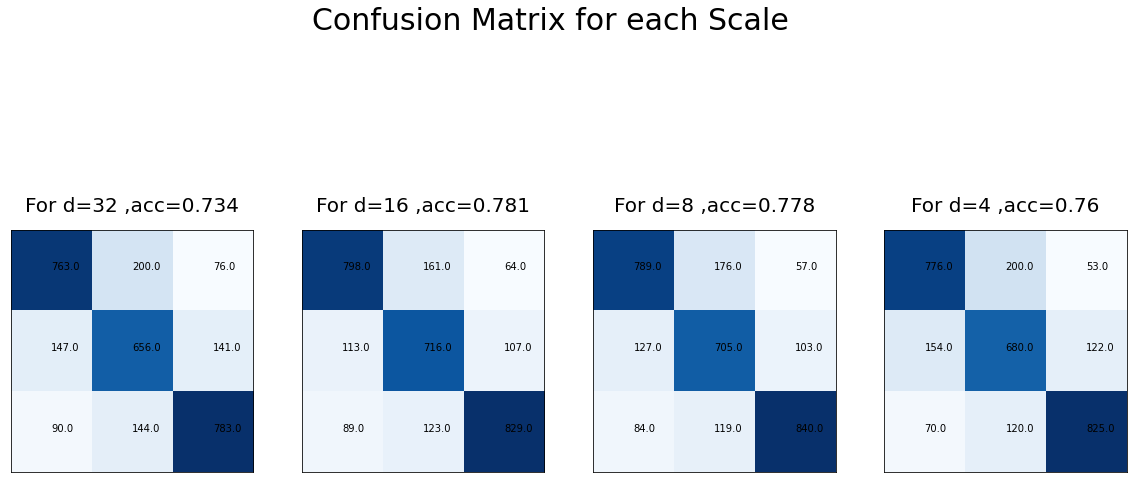

In [42]:
dims = [32,16,8,4,32,16,8,4]
fig, axs = plt.subplots(1, 4,figsize=(20,10))
fig.suptitle("Confusion Matrix for each Scale",fontsize=30)
for pi in range(0,axs.shape[0]):
  cm = confusion_matrices_gm[pi]
  axs[pi].matshow(cm,cmap="Blues")
  axs[pi].set_title("For d="+str(dims[pi])+" ,acc="+str(np.round(np.diag(cm).sum()/3000,3)),fontsize=20)
  for i in range(0,cm.shape[0]):
    for j in range(0,cm.shape[1]):
      axs[pi].set_xticks([])
      axs[pi].set_yticks([])
      axs[pi].annotate(cm[i,j],(j,i))

### Discussion

For this particular dataset, maximum likelihood classifiers performs better than Naïve Bayes classifiers. This is attributed to the often incorrect assumption of feature independence made by Naïve Bayes.

Since we are working with images, and each pixel represents a feature, one can clearly see that features are bound to be correlated (ex. pixels that make up the airplane, automobile, frog, or other objects). 


<center><img src="https://i.imgur.com/1TXTApx.png" width=200/></center>

In the above image (first image in the test set) we can clearly see that airplane pixels are correlated, runway pixels are correlated, sky pixels are correlated, etc.

One factor that affects the maximum likelihood classifiers is the  assumption of observation independence.  It is made for convenience but it does not reflect real data.

Finally, the fact that both classifiers are linear is also detrimental to their predictive power, since it does not capture the non-linear relationships here.  A kernel SVM might perform better in this case.

As for the image size, the smaller we resize the image, the more information we lose. Below 16x16, the algorithms struggle more with classifying images due to the detail loss. However, the difference of information loss between 16x16 and 32x32 is negligible. We can see in the image below that we can still make out the plane in the 32x32 and 16x16 images. At 8x8 the plane loses its shape and fuses with the runway. At 4x4 the whole image consists of 2 areas.

<center><img src="https://i.imgur.com/rkX2VvZ.png" width=600/></center>


In contrast, the difference between 32x32 and 16x16 can be explained by the curse of dimesionality. Increasing the feature space makes our data more sparse. Without more data, the classifier would find it easy to separate the training set in more than one way. The classifier would then start learning exceptions that are specific to the training data and do not generalize well when new data is encountered ([Source](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)).